# Model Objective


The objective of this model is to predict the presence of frog species on the basis of TerraClimate variables extracted from the Microsoft Planetary data catalog, which provides data for monthly climate and climatic water balance across global terrestrial surfaces from 1958 to the present.

In [1]:
!pip install rasterio

## Load In Dependencies


In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio


# Feature Engineering
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Machine Learning
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay

# Others
import os
from tqdm import tqdm

## Response Variable


In [3]:
# Load the training data from csv file and display the first few rows to inspect the data
ground_df = pd.read_csv("Training_Data.csv")
ground_df.head()

,Latitude,Longitude,Occurrence Status
0,-34.027900,150.771000,1
1,-34.821595,147.193697,1
2,-36.617759,146.882941,0
3,-37.470900,144.744000,1
4,-38.400153,145.018560,1


In [4]:
#Check dataframe shape.
ground_df.shape

(6312, 3)

In [5]:
tiff_path = "Complete_TerraClimate_output.tiff"

### Extracting Climatic variables from the TerraClimate sample GeoTiff file


In [6]:
# Extracts satellite variables from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data(tiff_path, csv_path):
    variable_names = [
      'aet', 'def', 'pdsi', 'pet', 'ppt', 'q', 'soil', 'srad',
      'swe', 'tmax', 'tmin', 'vap', 'vpd', 'ws'
    ]
    df = pd.read_csv(csv_path)

    # Open the GeoTIFF file and load data into xarray DataArrays
    with rasterio.open(tiff_path) as dataset:
        # Read raster variables into numpy arrays
        data_arrays = [dataset.read(i + 1) for i in range(14)]

        # Generate coordinate grids (lon/lat) from raster bounds and resolution
        lon = np.linspace(dataset.bounds.left, dataset.bounds.right, dataset.width)
        lat = np.linspace(dataset.bounds.top, dataset.bounds.bottom, dataset.height)

        # Create xarray DataArrays for each variable
        da_list = [
            xr.DataArray(
                data, coords=[("lat", lat), ("lon", lon)], dims=["lat", "lon"]
            ) for data in data_arrays
        ]

    # Initialize lists to store extracted values
    extracted_values = {var: [] for var in variable_names}

    # Extract values for each row in the DataFrame
    for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Extracting raster values"):
        target_lat, target_lon = row["Latitude"], row["Longitude"]

        # Extract values for each variable
        for var, da in zip(variable_names, da_list):
            try:
                value = da.sel(lat=target_lat, lon=target_lon, method="nearest").values
            except KeyError:
                value = np.nan
            extracted_values[var].append(value)

    # Create a DataFrame to store the variable values
    df_extracted = pd.DataFrame(extracted_values)

    return df_extracted

In [7]:
# Mapping satellite data with training data.
final_data = map_satellite_data('Complete_TerraClimate_output.tiff', 'Training_Data.csv')

Extracting raster values: 100%|██████████| 6312/6312 [01:26<00:00, 73.25it/s]


In [8]:
#Display first 5 rows.
final_data.head(5)

,aet,def,pdsi,pet,ppt,q,soil,srad,swe,tmax,tmin,vap,vpd,ws
0,53.5,65.30000305175781,-4.5,115.5,49.7,2.5,16.700000762939453,200.7991485595703,0.0,23.899999618530273,12.59999942779541,1.2330000400543213,0.8100000023841858,3.5999999046325684
1,24.700000762939453,110.9000015258789,-3.8999998569488525,144.6999969482422,25.900000000000002,1.3,2.5,218.40399169921875,0.0,24.5,10.899999618530273,0.9420000314712524,1.3299999237060547,3.0999999046325684
2,51.29999923706055,28.200000762939453,-3.799999952316284,115.0999984741211,69.9,3.5,68.80000305175781,204.00003051757812,0.0,21.399999618530273,8.09999942779541,0.9420000314712524,0.7799999713897705,3.1999998092651367
3,41.0,67.30000305175781,-4.699999809265137,120.70000457763672,45.0,2.3000000000000003,11.300000190734863,204.400146484375,0.0,20.19999885559082,8.0,0.9510000348091125,0.699999988079071,4.400000095367432
4,58.900001525878906,29.5,-4.799999713897705,109.5,71.10000000000001,3.6,43.0,189.20396423339844,0.0,18.899999618530273,9.899999618530273,1.096000075340271,0.5,5.599999904632568


## Joining the predictor variables and response variables

In [9]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined
    dataset2 - Dataset 2 to be combined
    '''

    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [10]:
# Combining ground data and final data into a single dataset.
final_data = combine_two_datasets(ground_df,final_data)
final_data.head()

,Latitude,Longitude,Occurrence Status,aet,def,pdsi,pet,ppt,q,soil,srad,swe,tmax,tmin,vap,vpd,ws
0,-34.027900,150.771000,1,53.5,65.30000305175781,-4.5,115.5,49.7,2.5,16.700000762939453,200.7991485595703,0.0,23.899999618530273,12.59999942779541,1.2330000400543213,0.8100000023841858,3.5999999046325684
1,-34.821595,147.193697,1,24.700000762939453,110.9000015258789,-3.8999998569488525,144.6999969482422,25.900000000000002,1.3,2.5,218.40399169921875,0.0,24.5,10.899999618530273,0.9420000314712524,1.3299999237060547,3.0999999046325684
2,-36.617759,146.882941,0,51.29999923706055,28.200000762939453,-3.799999952316284,115.0999984741211,69.9,3.5,68.80000305175781,204.00003051757812,0.0,21.399999618530273,8.09999942779541,0.9420000314712524,0.7799999713897705,3.1999998092651367
3,-37.470900,144.744000,1,41.0,67.30000305175781,-4.699999809265137,120.70000457763672,45.0,2.3000000000000003,11.300000190734863,204.400146484375,0.0,20.19999885559082,8.0,0.9510000348091125,0.699999988079071,4.400000095367432
4,-38.400153,145.018560,1,58.900001525878906,29.5,-4.799999713897705,109.5,71.10000000000001,3.6,43.0,189.20396423339844,0.0,18.899999618530273,9.899999618530273,1.096000075340271,0.5,5.599999904632568


In [11]:
final_data.to_csv('complete14-training-dataset.csv', index=False)

## Removing duplicates

In [12]:
# Import numpy if not already imported
import numpy as np

# Define the 14 climatic variables from TerraClimate
climatic_variables = [
    'aet', 'def', 'pdsi', 'pet', 'ppt', 'q', 'soil', 'srad',
      'swe', 'tmax', 'tmin', 'vap', 'vpd', 'ws'
]

# Define columns to check for duplicates
columns_to_check = climatic_variables + ['Occurrence Status']

# Convert any zero-dimensional NumPy arrays to scalars
for col in columns_to_check:
    final_data[col] = final_data[col].apply(lambda x: x.item() if isinstance(x, np.ndarray) and x.ndim == 0 else x)

# Remove duplicate rows based on specified columns, keeping the first occurrence
final_data = final_data.drop_duplicates(subset=columns_to_check, keep='first')

# Display the shape of the resulting DataFrame
print(final_data.shape)

(5285, 17)


## EDA

In [13]:
# Resetting the index of the dataset
final_data=final_data.reset_index(drop=True)

final_data.head()

final_data.to_csv('complete-training-dataset.csv', index=False)

#Create a copy of data.
model_data = final_data.copy()

#Summary statistics of data.
model_data.describe()

,Latitude,Longitude,Occurrence Status,aet,def,pdsi,pet,ppt,q,soil,srad,swe,tmax,tmin,vap,vpd,ws
count,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000,5285.000000
mean,-35.885904,146.648552,0.532640,41.173170,69.175309,-4.157729,121.776028,45.797824,2.362252,22.020000,206.579565,0.000132,21.822384,9.201741,1.001957,0.840184,3.854488
std,1.775698,2.717593,0.498981,14.102955,36.623188,0.809175,17.385434,18.904902,1.313312,31.490164,12.600953,0.005995,2.788198,2.210589,0.124070,0.344911,0.781725
min,-39.060582,140.244264,0.000000,9.600000,0.000000,-6.500000,78.599998,10.100000,0.500000,0.300000,177.800842,0.000000,10.000000,0.900000,0.564000,0.280000,2.600000
25%,-37.421008,144.575779,0.000000,31.300001,41.900002,-4.700000,108.900002,32.100000,1.600000,2.800000,197.198166,0.000000,19.799999,7.700000,0.938000,0.580000,3.200000
50%,-36.113491,146.613489,1.000000,41.299999,63.600002,-4.300000,116.400002,43.300000,2.200000,10.800000,205.000305,0.000000,21.299999,9.099999,0.978000,0.710000,3.600000
75%,-34.528288,149.102670,1.000000,50.500000,96.300003,-3.600000,133.600006,57.100000,2.900000,26.600000,216.299408,0.000000,23.900000,10.700000,1.050000,1.060000,4.300000
max,-30.947600,151.170776,1.000000,96.599998,148.400009,-2.300000,164.699997,127.800000,23.900000,210.900009,236.496948,0.400000,28.199999,14.799999,1.468000,1.730000,7.050000


In [14]:
# Define features and target.
x = model_data.iloc[:,0:-1]
y = model_data["Occurrence Status"].values

## XGBoost

In [15]:
# Install dependencies
!pip install optuna --quiet

# Imports
import optuna
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, classification_report, ConfusionMatrixDisplay

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 18.1 MB/s eta 0:00:00


In [16]:
# Features
base_features = ['soil', 'ppt', 'pdsi', 'tmax', 'vpd', 'tmin', 'def',
                 'q', 'aet', 'pet', 'ws', 'swe', 'srad', 'vap']
features = [f for f in base_features if f in x.columns]


In [17]:
# Split
X_train, X_test, y_train, y_test = train_test_split(x[features], y, test_size=0.2, stratify=y, random_state=42)

In [18]:
# Preprocessor
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", MinMaxScaler())
    ]), features)
])

In [19]:
# Function to create a pipeline from params
def create_pipeline(params):
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        **params
    )
    pipeline = Pipeline([
        ("preprocessing", preprocessor),
        ("classifier", model)
    ])
    return pipeline

In [20]:
# Objective function for Optuna
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500)
    }

    pipeline = create_pipeline(params)
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    return f1_score(y_test, preds)

In [21]:
# Run Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=40, timeout=600)

# Best params
print("Best Trial Parameters:")
print(study.best_trial.params)

[I 2025-04-07 04:18:23,232] A new study created in memory with name: no-name-8d9548f3-1f60-4964-8d58-97dfe365c78e
[I 2025-04-07 04:18:48,282] Trial 0 finished with value: 0.7071428571428572 and parameters: {'max_depth': 10, 'learning_rate': 0.10401140527170392, 'subsample': 0.7778730764315192, 'colsample_bytree': 0.8241935552904385, 'reg_alpha': 0.5919364861087116, 'reg_lambda': 1.1761818100696035, 'n_estimators': 305}. Best is trial 0 with value: 0.7071428571428572.
[I 2025-04-07 04:18:49,269] Trial 1 finished with value: 0.7251975417032485 and parameters: {'max_depth': 8, 'learning_rate': 0.07026894572823157, 'subsample': 0.8267158197765118, 'colsample_bytree': 0.6695798198375258, 'reg_alpha': 0.394609324926123, 'reg_lambda': 1.9980026133559365, 'n_estimators': 378}. Best is trial 1 with value: 0.7251975417032485.
[I 2025-04-07 04:18:49,983] Trial 2 finished with value: 0.7173524150268337 and parameters: {'max_depth': 8, 'learning_rate': 0.13421621090597854, 'subsample': 0.6370335687

Best Trial Parameters:
{'max_depth': 7, 'learning_rate': 0.02136237300983069, 'subsample': 0.7437342844050365, 'colsample_bytree': 0.8822852231216188, 'reg_alpha': 0.9995453253852639, 'reg_lambda': 0.0904742405527087, 'n_estimators': 265}


In [22]:
# Final model
final_pipeline = create_pipeline(study.best_trial.params)
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['soil', 'ppt', 'pdsi',
                                                   'tmax', 'vpd', 'tmin', 'def',
                                                   'q', 'aet', 'pet', 'swe',
                                                   'srad', 'vap'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsamp...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.02136237300983069, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=7,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=265,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])

In [23]:
# Save pipeline
joblib.dump(final_pipeline, "optuna_xgboost_pipeline_V1.pkl")
print("Pipeline saved!")

Pipeline saved!



Test Set F1 Score: 0.7578589634664401
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.66      0.70       494
           1       0.73      0.79      0.76       563

    accuracy                           0.73      1057
   macro avg       0.73      0.73      0.73      1057
weighted avg       0.73      0.73      0.73      1057



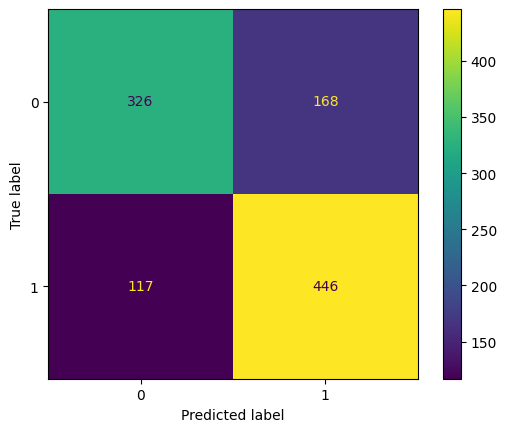

In [24]:
# Evaluation
y_pred = final_pipeline.predict(X_test)
print("\nTest Set F1 Score:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(final_pipeline, X_test, y_test)


In [25]:
# Predict on validation data
test_file = pd.read_csv("Validation_Template.csv")
final_val_data = map_satellite_data("Complete_TerraClimate_output.tiff", "Validation_Template.csv")

loaded_pipeline = joblib.load("optuna_xgboost_pipeline_V1.pkl")
final_predictions = loaded_pipeline.predict(final_val_data)

submission_df = pd.DataFrame({
    'Latitude': test_file['Latitude'],
    'Longitude': test_file['Longitude'],
    'Occurrence Status': final_predictions
})
display(submission_df)

submission_df.to_csv("Predicted_Data_XGBoost_Optuna_V1.csv", index=False)

Extracting raster values: 100%|██████████| 2000/2000 [00:32<00:00, 61.17it/s]


,Latitude,Longitude,Occurrence Status
0,-33.121788,150.320746,1
1,-36.592011,148.172262,0
2,-35.455100,146.693465,0
3,-33.076261,149.547177,1
4,-35.529729,146.627272,0
...,...,...,...
1995,-33.342761,145.736478,0
1996,-34.455690,150.442003,1
1997,-36.241444,144.720379,1
1998,-32.194000,148.900320,1
